<a href="https://colab.research.google.com/github/Yutong-Lu/CHL5230FinalProject/blob/main/Updated_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import plotly.express as px
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import RocCurveDisplay, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
import warnings

warnings.filterwarnings('ignore')

In [12]:
data = pd.read_excel('Diabetes Study File 10K Dec 14 2017.xlsx')
data.head()

,Age_at_Exam,sBP,sBP_Date,BMI,BMI_Date,LDL,LDL_Date,HDL,HDL_Date,A1c,...,leastO(A1c_Date),leastO(DM_OnsetDate),leastO(FBS_Date),LeastOfAll,A1C_BEF_DM,FBS_BEF_DM,Patient_ID,DM_Onset_Revised,DM_Onset_Revised_1YrPrior,DIABETES
0,65,126.0,2013-06-11,31.000000,2013-06-11,1.66,2013-06-14,1.11,2013-06-14,5.4,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000255903,NaT,NaT,No
1,62,135.0,2014-06-19,25.846483,2014-10-17,2.49,2014-05-28,1.37,2014-05-28,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000256456,NaT,NaT,No
2,63,133.0,2012-07-31,30.900000,2011-12-01,1.65,2012-06-01,NaN,NaT,6.1,...,NaN,NaN,NaN,NaN,NaN,NaN,1001000000000054,NaT,NaT,No
3,51,136.0,2014-01-06,56.710775,2014-01-06,2.80,2014-01-14,1.94,2014-01-14,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000259496,NaT,NaT,No
4,40,123.0,2015-06-12,33.067867,2015-06-12,2.48,2015-06-24,1.17,2015-06-24,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000262094,NaT,NaT,No


In [13]:
# Replace categorical values with numerical equivalents
data['DIABETES'].replace({'Yes' : 1, 'No' : 0}, inplace=True)
data['Sex'].replace({'Female' : 1, 'Male' : 0}, inplace=True)

# Create indicator for using hypertension meds/corticosteroid
data['Use_of_Hypertension_Medications'] = data['Hypertension_Medications'].notnull().astype('int')
data['Use_of_Corticosteroids'] = data['Corticosteroids'].notnull().astype('int')

In [14]:
# Create a subset with no date
df = data[['Age_at_Exam', 'sBP', 'BMI', 'A1c', 'TG', 'FBS', 'Total_Cholesterol', 'Depression',
     'HTN', 'OA', 'COPD', 'Use_of_Hypertension_Medications', 'Use_of_Corticosteroids', 'Sex', 'DIABETES']]

numerical_columns = ['Age_at_Exam', 'sBP', 'BMI', 'A1c', 'TG', 'FBS', 'Total_Cholesterol']

In [15]:
# define features and outcome
X = df.drop(['DIABETES'], axis=1)
y = df[['DIABETES']]

# split training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=1)

# Normalizing data
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((7000, 14), (1500, 14), (1500, 14), (7000, 1), (1500, 1), (1500, 1))

In [16]:
# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_filled_mice = imputer.fit_transform(X_train)
X_val_filled_mice = imputer.transform(X_val)
X_test_filled_mice = imputer.transform(X_test)

In [17]:
# Check multicollinearity
# VIF dataframe
X_train_filled_mice_df = pd.DataFrame(X_train_filled_mice)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_filled_mice_df.columns


# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_filled_mice_df.values, i)
                          for i in range(len(X_train_filled_mice_df.columns))]

print(vif_data)
# All good after removing LDL and HDL

    feature       VIF
0         0  1.220620
1         1  1.122415
2         2  1.118326
3         3  2.546792
4         4  1.254313
5         5  2.612574
6         6  1.285354
7         7  1.332063
8         8  4.562149
9         9  1.569685
10       10  1.148996
11       11  4.905079
12       12  1.447272
13       13  1.999843


In [18]:
# take a look at training X
for col in X.columns:
    print(col)

Age_at_Exam
sBP
BMI
A1c
TG
FBS
Total_Cholesterol
Depression
HTN
OA
COPD
Use_of_Hypertension_Medications
Use_of_Corticosteroids
Sex


In [19]:
# Initializing the Gradient Boosting Classifier with specified parameters
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Defining the hyperparameters to be tuned using GridSearchCV
param_dist = {
    "n_estimators" : [100, 200],
    "max_depth" : [1, 3, 5],
    "min_samples_leaf" : [25, 50],
    "learning_rate" : [.1,  .2]
}

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=10)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(model, param_grid=param_dist, cv=skf)

# Fitting the GridSearchCV on the training data
# GradientBoostingClassifier does not accept missing values encoded as NaN natively.
# For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively.
random_search.fit(X_val_filled_mice, y_val)

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.147954,0.012130,0.001026,0.000118,0.1,1,25,100,"{'learning_rate': 0.1, 'max_depth': 1, 'min_sa...",0.866667,...,0.840000,0.873333,0.886667,0.860000,0.813333,0.900000,0.846667,0.861333,0.036490,1
2,0.149458,0.007191,0.001194,0.000191,0.1,1,50,100,"{'learning_rate': 0.1, 'max_depth': 1, 'min_sa...",0.866667,...,0.840000,0.873333,0.886667,0.860000,0.813333,0.906667,0.840000,0.861333,0.037571,1
6,0.296847,0.031250,0.001464,0.000252,0.1,3,50,100,"{'learning_rate': 0.1, 'max_depth': 3, 'min_sa...",0.853333,...,0.853333,0.853333,0.886667,0.866667,0.826667,0.920000,0.853333,0.861333,0.034998,1
14,0.142805,0.003634,0.001063,0.000146,0.2,1,50,100,"{'learning_rate': 0.2, 'max_depth': 1, 'min_sa...",0.860000,...,0.846667,0.880000,0.880000,0.853333,0.820000,0.920000,0.846667,0.861333,0.036974,1


In [20]:
random_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 1,
 'min_samples_leaf': 25,
 'n_estimators': 100}

In [21]:
# Updating the model's parameters with the best ones found from GridSearchCV
model = model.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train_filled_mice, y_train)

# Predicting on the training dataset and computing the accuracy
y_pred_train = model.predict(X_train_filled_mice)
print(accuracy_score(y_train, y_pred_train))

# Predicting on the test dataset and computing the accuracy
y_pred_test = model.predict(X_test_filled_mice)
print(accuracy_score(y_test, y_pred_test))

print(classification_report(y_pred_train, y_train))
print(classification_report(y_pred_test, y_test))

0.8664285714285714
0.8533333333333334
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      3626
           1       0.84      0.90      0.87      3374

    accuracy                           0.87      7000
   macro avg       0.87      0.87      0.87      7000
weighted avg       0.87      0.87      0.87      7000

              precision    recall  f1-score   support

           0       0.88      0.83      0.86       791
           1       0.83      0.87      0.85       709

    accuracy                           0.85      1500
   macro avg       0.85      0.85      0.85      1500
weighted avg       0.85      0.85      0.85      1500



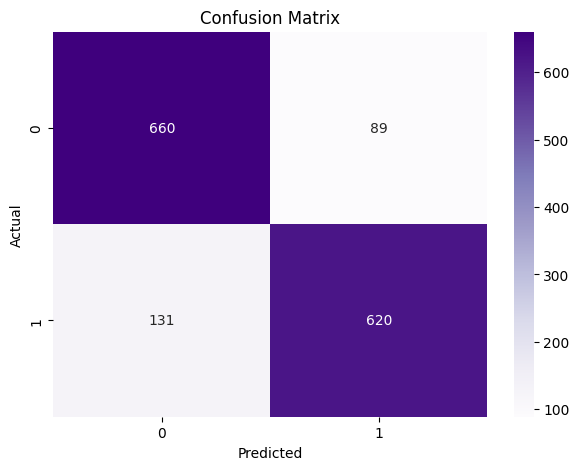

In [22]:
# Get unique classes
classes = df['DIABETES'].unique()

# Plotting the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_test),
            cmap='Purples', annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Depression vs no depression with XGBoost

In [27]:
# separate the data set into two sets
dep = df[df['Depression'] == 1]
no_dep = df[df['Depression'] == 0]

# check if all observations are covered
print(f'The number of observations with depression in this data set is {len(dep)}')
print(f'The number of observations without depression in this data set is {len(no_dep)}')

The number of observations with depression in this data set is 2122
The number of observations without depression in this data set is 7878


XGBoost for people with depression

The number of observations in the training set with diabetes is [727]
The number of observations in the training set without diabetes is [757]
0.8598382749326146
0.8808777429467085
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       841
           1       0.80      0.90      0.85       643

    accuracy                           0.86      1484
   macro avg       0.86      0.86      0.86      1484
weighted avg       0.87      0.86      0.86      1484

              precision    recall  f1-score   support

           0       0.94      0.85      0.90       191
           1       0.81      0.92      0.86       128

    accuracy                           0.88       319
   macro avg       0.88      0.89      0.88       319
weighted avg       0.89      0.88      0.88       319



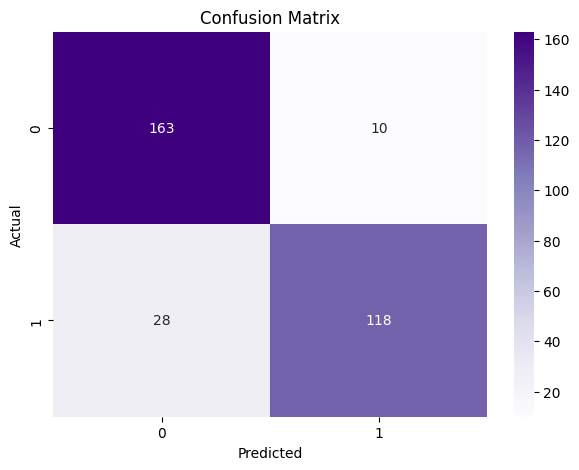

In [29]:
# run XGBoost on people with depression first

# define features and outcome
X = dep.drop(['DIABETES'], axis=1)
y = dep[['DIABETES']]

# split training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=1)

# Normalizing data
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# check class imbalance

print(f'The number of observations in the training set with diabetes is {sum(y_train == 1)}')
print(f'The number of observations in the training set without diabetes is {sum(y_train == 0)}')

# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_filled_mice = imputer.fit_transform(X_train)
X_val_filled_mice = imputer.transform(X_val)
X_test_filled_mice = imputer.transform(X_test)

# Initializing the Gradient Boosting Classifier with specified parameters
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Defining the hyperparameters to be tuned using GridSearchCV
param_dist = {
    "n_estimators" : [100, 200],
    "max_depth" : [1, 3, 5],
    "min_samples_leaf" : [25, 50],
    "learning_rate" : [.1,  .2]
}

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=10)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(model, param_grid=param_dist, cv=skf)

# Fitting the GridSearchCV on the training data
random_search.fit(X_val_filled_mice, y_val)

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

# Updating the model's parameters with the best ones found from GridSearchCV
model = model.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train_filled_mice, y_train)

# Predicting on the training dataset and computing the accuracy
y_pred_train = model.predict(X_train_filled_mice)
print(accuracy_score(y_train, y_pred_train))

# Predicting on the test dataset and computing the accuracy
y_pred_test = model.predict(X_test_filled_mice)
print(accuracy_score(y_test, y_pred_test))

print(classification_report(y_pred_train, y_train))
print(classification_report(y_pred_test, y_test))

# Get unique classes
classes = dep['DIABETES'].unique()

# Plotting the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_test),
            cmap='Purples', annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

XGBoost for people without depression

The number of observations in the training set with diabetes is [2912]
The number of observations in the training set without diabetes is [2602]
0.8628944504896626
0.8764805414551607
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      2772
           1       0.84      0.89      0.87      2742

    accuracy                           0.86      5514
   macro avg       0.86      0.86      0.86      5514
weighted avg       0.86      0.86      0.86      5514

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       589
           1       0.86      0.90      0.88       593

    accuracy                           0.88      1182
   macro avg       0.88      0.88      0.88      1182
weighted avg       0.88      0.88      0.88      1182



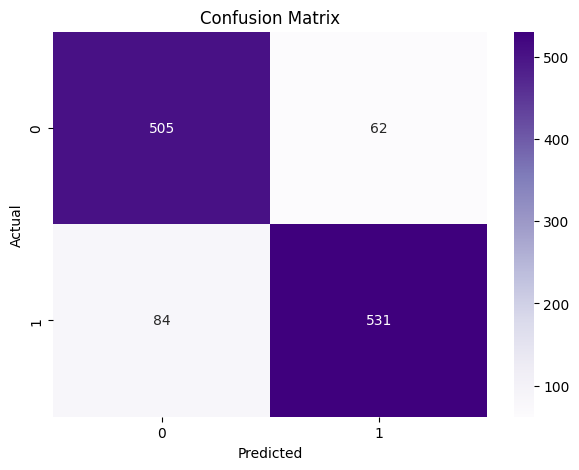

In [31]:
# define features and outcome
X = no_dep.drop(['DIABETES'], axis=1)
y = no_dep[['DIABETES']]

# split training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=1)

# Normalizing data
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# check class imbalance

print(f'The number of observations in the training set with diabetes is {sum(y_train == 1)}')
print(f'The number of observations in the training set without diabetes is {sum(y_train == 0)}')

# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_filled_mice = imputer.fit_transform(X_train)
X_val_filled_mice = imputer.transform(X_val)
X_test_filled_mice = imputer.transform(X_test)

# Initializing the Gradient Boosting Classifier with specified parameters
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Defining the hyperparameters to be tuned using GridSearchCV
param_dist = {
    "n_estimators" : [100, 200],
    "max_depth" : [1, 3, 5],
    "min_samples_leaf" : [25, 50],
    "learning_rate" : [.1,  .2]
}

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=10)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(model, param_grid=param_dist, cv=skf)

# Fitting the GridSearchCV on the training data
random_search.fit(X_val_filled_mice, y_val)

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

# Updating the model's parameters with the best ones found from GridSearchCV
model = model.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train_filled_mice, y_train)

# Predicting on the training dataset and computing the accuracy
y_pred_train = model.predict(X_train_filled_mice)
print(accuracy_score(y_train, y_pred_train))

# Predicting on the test dataset and computing the accuracy
y_pred_test = model.predict(X_test_filled_mice)
print(accuracy_score(y_test, y_pred_test))

print(classification_report(y_pred_train, y_train))
print(classification_report(y_pred_test, y_test))

# Get unique classes
classes = dep['DIABETES'].unique()

# Plotting the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_test),
            cmap='Purples', annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()